In [1]:
using MAT
using Glob
using WebIO
using PyPlot
using Eirene

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-3001965140517974063\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-18190297162663244212\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-3001965140517974063\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

#### TODO:
- Calculate persistence imgs for all wells and compute Euclidean distance between persistance imgs
    - $\frac{1}{nx \times ny} \sum_{x}\sum_{y} |I_1(x,y) - I_2(x,y)|^2$

#### Load data

In [3]:
filelist = glob("EGF(E6)w*.mat", "experimental-data")
sz = size(filelist)[1];

well_nums = []
particle_pos = []

for i in 1:sz
    
    filenamewext = split(filelist[i], '/')[2]
    filename = split(filenamewext, '.')[1]
    well_num = parse(Int, split(filename, 'w')[2])
    
    mat_variables = matread(filelist[i])
    pos_x = mat_variables["storeX"]
    pos_y = mat_variables["storeY"]
    pos_x_final = pos_x[1:end, size(pos_x)[2]]
    pos_y_final = pos_y[1:end, size(pos_y)[2]]
    pos_x_final = filter!(!(isnan), pos_x_final)
    pos_y_final = filter!(!(isnan), pos_y_final)
    pos_final = hcat(pos_x_final, pos_y_final)
    pos_final = transpose(pos_final)
    
    push!(well_nums, well_num)
    push!(particle_pos, pos_final)
    
end

#### Sort by well number

In [4]:
sort_idx = sortperm(well_nums)
well_nums = well_nums[sort_idx];
particle_pos = particle_pos[sort_idx];

#### Compute peristence diagrams and barcodes

In [5]:
@time begin

    barcodes = []

    for i in 1:sz
        pers_diag = eirene(particle_pos[i], model="pc", maxdim=1)
        push!(barcodes, barcode(pers_diag))
    end
    
end

 65.152411 seconds (163.61 M allocations: 29.409 GiB, 11.11% gc time)


#### Compute pairwise Wasserstein distances

In [6]:
@time begin
    
    wassmatrix = Array{Float64}(undef, sz, sz);
    for rows in 1:sz
        for cols in 1:sz
            wassmatrix[rows, cols] = wasserstein_distance(barcodes[rows], barcodes[cols], q=2, p=2);
        end
    end
    
end

 84.242206 seconds (6.55 M allocations: 1014.513 MiB, 0.28% gc time)


In [27]:
well_names = []

for i in 1:sz
    push!(well_names, "Well " * string(well_nums[i]))
end

#### Plot heatmap

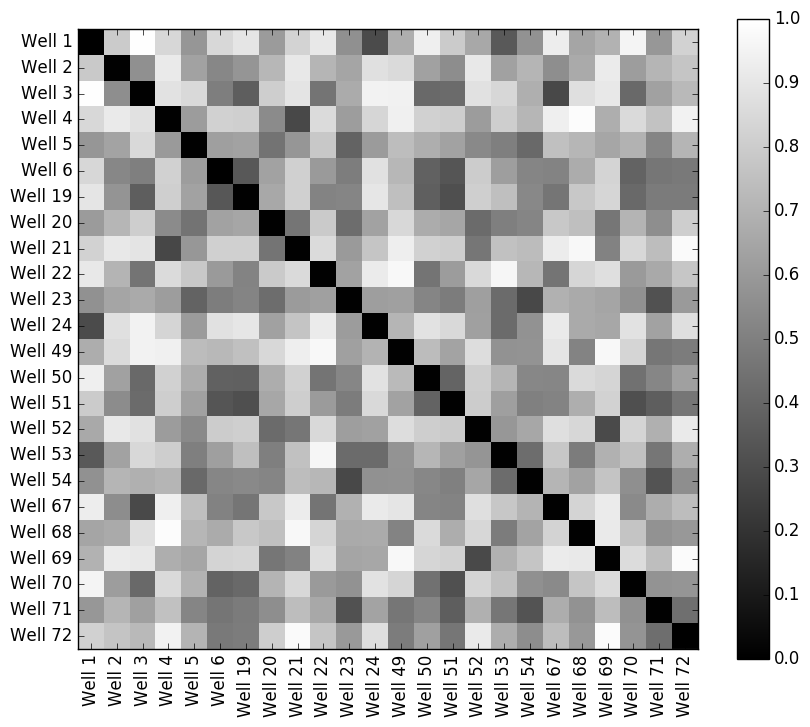

In [43]:
max_coord = maximum(wassmatrix)
wassmatrix = wassmatrix/max_coord

figure(figsize=(10,8), dpi=300);
imshow(wassmatrix, cmap="gray", interpolation="none");
xticks(0:sz-1, well_names, rotation=90);
yticks(0:sz-1, well_names);
colorbar();